In [1]:
import os
import sys
from pathlib import Path
import warnings
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import yaml
import importlib
import numpy as np
import gvar as gv
import platform
cwd = Path(os.getcwd())
# Assuming your notebook is in the project root, set the project root as cwd
project_root = cwd.parent
print(project_root)
# If your notebook is in a subdirectory of the project root, you can modify the path accordingly:
# project_root = cwd.parent  # Go up one directory level
# project_root = cwd.parent.parent  # Go up two directory levels
# Add the project root directory to sys.path
sys.path.insert(0, str(project_root))
# sys.path.append('../')

# local imports 
import xpt.fit_analysis as xfa
import xpt.priors as priors
import xpt.i_o as i_o
import xpt.fit_routine as fit
import xpt.plots as plots
warnings.simplefilter(action="default")
warnings.filterwarnings('ignore')


/home/gmoney/lqcd/hyperon-xpt-master


In [2]:
from importlib import reload
from tabulate import tabulate
importlib.reload(xfa)
importlib.reload(i_o)
importlib.reload(fit)
importlib.reload(priors)

<module 'xpt.priors' from '/home/gmoney/lqcd/hyperon-xpt-master/xpt/priors.py'>

In [3]:
# Define paths and other variables
if platform.system() == 'Darwin':
    base_dir = '/Users/grantdb/lqcd/hyperon-xpt-master'
else:
    base_dir = '/home/gmoney/lqcd/hyperon-xpt-master'

data_dir = os.path.join(base_dir, "data")
hyperon_data_file = os.path.join(data_dir,"hyperon_data.h5")
# bs_data_file = os.path.join(data_dir, "hyperon_bs_data.h5")
t_plot_min = 0
t_plot_max = 40
prior = priors.get_prior(units='mev')
input_output = i_o.InputOutput()
data, ens = input_output.get_data(units='phys')
new_prior = input_output.make_prior(data=data,prior=prior)
phys_point_data = input_output.get_data_phys_point()

## Xi, Xi* system SU(2) HBXPT extrapolation ##


In [4]:
# importlib.reload(xfa)
# importlib.reload(fit)
# importlib.reload(i_o)

# with open('../xpt/models.yaml', 'r') as f:
#     models = yaml.load(f, Loader=yaml.FullLoader)
# xi_models = models['models']['xi_system']
# for mdl_key in xi_models:
#     mdl_info = xi_models[mdl_key]
# my_fit = fit.FitRoutine(phys_point_data=phys_point_data,emp_bayes=None,empbayes_grouping=None,
#                                 data=data,model_info=xi_models['xi:xi_st:d_n2lo:l_n2lo:x_n2lo'],prior=new_prior)
# xi_sys_out = my_fit.fit
# print(xi_sys_out.p)
# extrap_analysis = xfa.fit_analysis(verbose=True,phys_point_data=phys_point_data,
#                                 data=data,model_info=mdl_info,prior=new_prior)


In [5]:
from scipy.interpolate import interp1d
importlib.reload(xfa)

def perform_fit_and_plot(model_type,mdl_key):
    mdl_info = model_type[mdl_key]
    extrap_analysis = xfa.fit_analysis(verbose=False, phys_point_data=phys_point_data,
                                data=data, model_info=mdl_info, prior=new_prior)
    fit_out = extrap_analysis.fit
    print(fit_out)
    print(f"Model: {mdl_key}")
    print(extrap_analysis)

    # x_data = [gv.mean(x) for x in extrap_analysis.fit.p['eps2_a']]
    # for part in mdl_info['particles']:
    #     y_data = [gv.mean(y) for y in extrap_analysis.fit.y[part]]

    # y_fit = interp1d(x_data, y_data, kind='cubic', fill_value='extrapolate')

    # x_fit = np.linspace(-0.1, 0.1, 100)
    # y_fit_vals = [y_fit(x) for x in x_fit]

    # plt.plot(x_fit, y_fit_vals, label=f"{mdl_key}")
    # plt.fill_between(x_fit, [y - gv.sdev(y) for y in y_fit_vals], [y + gv.sdev(y) for y in y_fit_vals], alpha=0.5)

    # plt.axvline(0, ls='--', color='black', label='phys. point')
    # y_phys = np.mean([gv.gvar(g) for g in ['1314.86(20)', '1321.71(07)']])
    
    # plt.plot(0, gv.mean(y_phys), marker='o', mec='w', zorder=0.2, color='black')

    # plt.xlabel("$\epsilon_a^2$")
    # plt.ylabel("$m_\Xi(MeV)$")
    # plt.legend()
    # plt.grid()
    # plt.show()
    return fit_out


In [10]:
def plot_params(fit,yparam,xparam=None):
    if xparam is None:
        xparam = 'eps2_a'
    colormap = {
        'a06' : '#6A5ACD',
        'a09' : '#51a7f9',
        'a12' : '#70bf41',
        'a15' : '#ec5d57',
    }

    x = {}
    y = {}
    baryon_latex = {
                'sigma': '\Sigma',
                'sigma_st': '\Sigma^*',
                'xi': '\Xi',
                'xi_st': '\Xi^*',
                'lambda': '\Lambda'
            }

    for i in range(len(ens)):
        for j, param in enumerate([xparam, yparam]):
            if param in baryon_latex.keys():
                value = fit.y[yparam][i]
                latex_baryon = baryon_latex[param]
                label = f'$m_{{{latex_baryon}}}$(MeV)'
            if param =='eps2_a':
                value = data['eps2_a'][i] 
                label = '$\epsilon_a^2$'
            if param == 'm_pi_sq':
                value = data['m_pi']**2[i] 
                label = '$m_\pi^2$'
            if j == 0:
                x[i] = value
                xlabel = label
            elif j == 1:
                y[i] = value
                ylabel = label

    added_labels = set()

    for i in range(len(ens)):
        C = gv.evalcov([x[i], y[i]])
        eVe, eVa = np.linalg.eig(C)
        color_key = ens[i][:3]
        color = colormap[color_key]
        label = f'{color_key.lower()}'

        for e, v in zip(eVe, eVa.T):
            plt.plot([gv.mean(x[i])-1*np.sqrt(e)*v[0], 1*np.sqrt(e)*v[0] + gv.mean(x[i])],
                    [gv.mean(y[i])-1*np.sqrt(e)*v[1], 1*np.sqrt(e)*v[1] + gv.mean(y[i])],
                        alpha=1.0, lw=2, color=color)

            if label not in added_labels:
                plt.plot(gv.mean(x[i]), gv.mean(y[i]), 
                        marker='o', mec='w', zorder=3, color=color, label=label)
                added_labels.add(label)
            else:
                plt.plot(gv.mean(x[i]), gv.mean(y[i]), 
                        marker='o', mec='w', zorder=3, color=color)
                
        
    phys_point_yparam = gv.mean(np.mean([gv.gvar(g) for g in ['1314.86(20)', '1321.71(07)']]))
    phys_point_xparam = 0.0
    if yparam in baryon_latex.keys():
        latex_baryon = baryon_latex[param]
        label = f'$m_{{{latex_baryon}}}$'
    plt.axvline(phys_point_xparam, ls='--', color='black', label=label)
    plt.plot(phys_point_xparam, phys_point_yparam, marker='o', color='black', zorder=4)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),
        ncol=len(by_label), bbox_to_anchor=(0,1), loc='lower left')
    plt.grid()
    plt.xlabel(xlabel, fontsize = 24)
    plt.ylabel(ylabel, fontsize = 24)

    fig = plt.gcf()
    plt.show()
    plt.close()
    return fig 


In [7]:
with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
lam_sig_models = models['models']['lam_sigma_system']
for mdl_key in lam_sig_models:
    try:
        perform_fit_and_plot(lam_sig_models,mdl_key)
    except Exception as e:
        print(f"Error encountered for Model: {mdl_key}")
        print(f"Error details: {e}")
        continue
    

{'m_{lambda,0}': 1000(50), 's_{lambda}': 0.0(5.0), 'd_{lambda,a}': 0.0(5.0), 'd_{lambda,aa}': 0.0(5.0), 'd_{lambda,al}': 0.0(5.0), 'm_{sigma,0}': 1200(50), 's_{sigma}': 0.0(5.0), 'd_{sigma,a}': 0.0(5.0), 'd_{sigma,aa}': 0.0(5.0), 'd_{sigma,al}': 0.0(5.0), 'm_{sigma_st,0}': 1400(50), 's_{sigma,bar}': 0.0(5.0), 'd_{sigma_st,a}': 0.0(5.0), 'd_{sigma_st,aa}': 0.0(5.0), 'd_{sigma_st,al}': 0.0(5.0), 'eps2_a': array([0.029618(41), 0.065325(70), 0.066506(83), 0.06877(16), 0.06998(19),
       0.07160(20), 0.123786(95), 0.12594(12), 0.13008(23), 0.13214(20),
       0.13446(16), 0.19514(12), 0.19737(28), 0.20368(32), 0.20416(25),
       0.20706(48), 0.21168(56)], dtype=object), 'm_pi': array([327.6(2.9), 134.5(1.1), 221.4(1.8), 318.4(2.6), 357.1(2.9),
       409.4(3.3), 132.3(1.0), 219.3(1.6), 308.1(2.3), 349.5(2.6),
       397.9(2.9), 134.67(90), 216.7(1.5), 309.9(2.1), 306.8(2.1),
       347.8(2.3), 397.3(2.7)], dtype=object), 'lam_chi': array([1320(12), 1158.7(9.7), 1213(10), 1294(11), 1323(11

{'m_{lambda,0}': 1000(50), 's_{lambda}': 0.0(5.0), 'd_{lambda,a}': 0.0(5.0), 'd_{lambda,aa}': 0.0(5.0), 'd_{lambda,al}': 0.0(5.0), 'd_{lambda,s}': 0.0(5.0), 'm_{sigma,0}': 1200(50), 's_{sigma}': 0.0(5.0), 'd_{sigma,a}': 0.0(5.0), 'd_{sigma,aa}': 0.0(5.0), 'd_{sigma,al}': 0.0(5.0), 'd_{sigma,s}': 0.0(5.0), 'm_{sigma_st,0}': 1400(50), 's_{sigma,bar}': 0.0(5.0), 'd_{sigma_st,a}': 0.0(5.0), 'd_{sigma_st,aa}': 0.0(5.0), 'd_{sigma_st,al}': 0.0(5.0), 'd_{sigma_st,s}': 0.0(5.0), 'm_k': array([561.8(5.0), 493.9(4.0), 517.0(4.2), 544.9(4.4), 558.3(4.5),
       576.9(4.6), 493.9(3.6), 507.4(3.7), 529.9(3.9), 545.1(4.0),
       561.3(4.1), 508.0(3.4), 507.3(3.4), 530.6(3.5), 529.5(3.5),
       543.1(3.6), 560.5(3.7)], dtype=object), 'eps2_a': array([0.029618(41), 0.065325(70), 0.066506(83), 0.06877(16), 0.06998(19),
       0.07160(20), 0.123786(95), 0.12594(12), 0.13008(23), 0.13214(20),
       0.13446(16), 0.19514(12), 0.19737(28), 0.20368(32), 0.20416(25),
       0.20706(48), 0.21168(56)], dtype

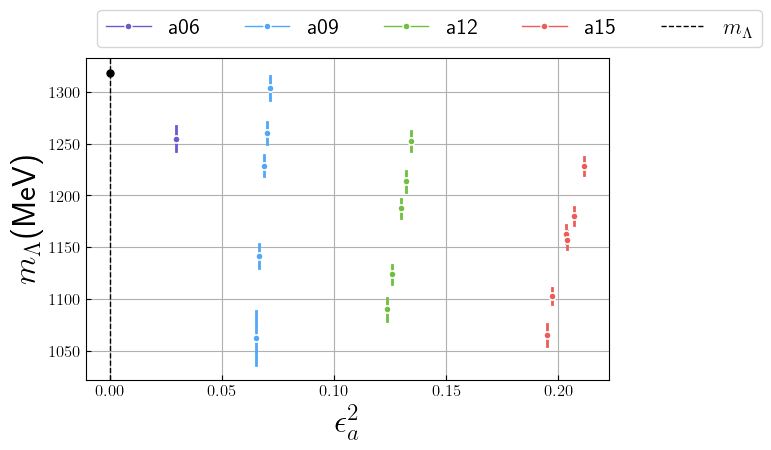

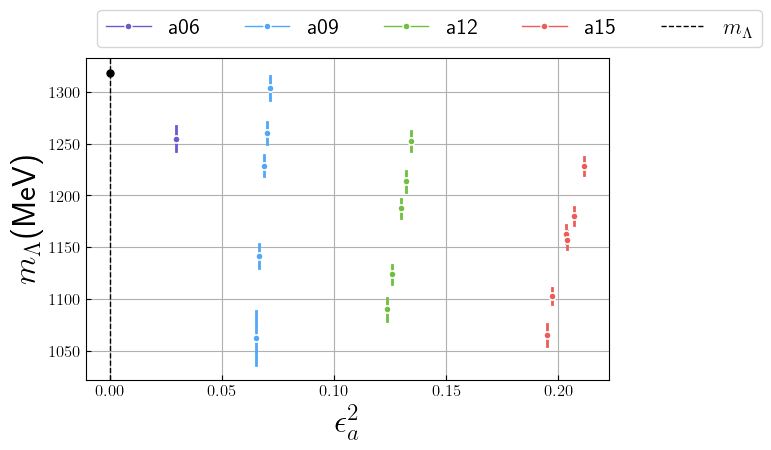

In [12]:
lam_sig_models = models['models']['lam_sigma_system']
model_info = lam_sig_models['lam:sigma:sigma_st:l_lo:d_n2lo:s_lo']
my_fit = fit.FitRoutine(phys_point_data=phys_point_data,emp_bayes=None,empbayes_grouping=None,
                                data=data,model_info=model_info,prior=new_prior)
lam_sigma_sys_out = my_fit.fit
plot_params(fit=lam_sigma_sys_out,yparam='lambda')

In [ ]:
lam_sigma_fit = perform_fit_and_plot(model_type=mod)
plot_params()

### Lambda, Sigma, Sigma_star SU(2) hbxpt extrapolation

In [ ]:
with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
lam_sig_models = models['models']['lam_sigma_system']
for mdl_key in lam_sig_models:
    perform_fit_and_plot(lam_sig_models,mdl_key)

Model: lam:sigma:sigma_st:l_n2lo:s_n2lo:d_n2lo:x_n2lo

---
Least Square Fit:
  chi2/dof [dof] = 0.99 [51]    Q = 0.49    logGBF = -247.67

Parameters:
         m_{lambda,0}         1039.01 +- 26.9751            [               1000 +- 50 ]  
           s_{lambda}          2.1043 +- 1.00877            [                   0 +- 5 ]  
         b_{lambda,4}        0.882997 +- 4.37478            [                   0 +- 5 ]  
         d_{lambda,a}      0.0539212 +- 0.312282            [                   0 +- 5 ]  
        d_{lambda,aa}       -0.149455 +- 1.18896            [                   0 +- 5 ]  
        d_{lambda,al}        -3.55825 +- 3.39301            [                   0 +- 5 ]  
         d_{lambda,s}       -1.02076 +- 0.783243            [                   0 +- 5 ]  
        d_{lambda,as}         4.15861 +- 3.30558            [                   0 +- 5 ]  
        d_{lambda,ls}          2.4444 +- 4.66278            [                   0 +- 5 ]  
        d_{lambda,ss}        -

KeyError: 'undefined key: a_{sigma,4}'